# MLBD : Project on the music dataset

The base subject is : Predicting a playlist that satisfies group members (e.g., to decide the music to play in a party). By playlist we mean a set of songs that can be from the same artist or multiple ones.

Research questions : 
- How do we compute the metrics for similarity between user ?
- What is the impact of the number of plays ?
- What is the impact of the gender, age and country on the kind of music people are listening to ?
- Not a question : Use the Spotify API to access to the genre, maybe. (using Spotipy)
- See what we can get from the Spotify API !
- Can we generate a music playlist for multiple users based on what they listened?

### 1. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth
#import credentials
import ast
import os

In [2]:
#sp = spotipy.Spotify(auth_manager = SpotifyClientCredentials(client_id = credentials.clientId, client_secret = credentials.clientSecret))

### 2. Load the data

In [2]:
DATA_FOLDER = 'data/'
TOP_FOLDER = DATA_FOLDER + 'lastfm-dataset-360k/'
TIMELINE_FOLDER = DATA_FOLDER + 'lastfm-dataset-1k/'

top_user = pd.read_csv(TOP_FOLDER + 'usersha1-profile.tsv', sep = '\t', error_bad_lines = False, header = None)
top_data = pd.read_csv(TOP_FOLDER + 'usersha1-artmbid-artname-plays.tsv', sep = '\t', error_bad_lines = False, header = None)

timeline_user = pd.read_csv(TIMELINE_FOLDER + 'userid-profile.tsv', sep = '\t', error_bad_lines = False, header = 0)
timeline_data = pd.read_csv(TIMELINE_FOLDER + 'userid-timestamp-artid-artname-traid-traname.tsv', sep = '\t', error_bad_lines = False, header = None)

# This file was created using the data expansion done in part 4
spotify_data = pd.read_csv(DATA_FOLDER + 'full_spotify_info.csv', error_bad_lines = False, header = 0)

top_user.rename(columns = {0 : 'ID', 1 : 'Gender', 2 : 'Age', 3 : 'Country', 4 : 'Registered'}, inplace = True)
top_data.rename(columns = {0 : 'ID', 1 : 'Artist_ID', 2 : 'Artist', 3 : 'Plays'}, inplace = True)
timeline_user.rename(columns = {'#id' : 'ID', 'gender' : 'Gender', 'age' : 'Age', 'country' : 'Country', 'registered' : 'Registered'}, inplace = True)
timeline_data.rename(columns = {0 : 'ID', 1 : 'Timestamp', 2 : 'Artist_ID', 3 : 'Artist', 4 : 'Track_ID', 5 : 'Track'}, inplace = True)

b'Skipping line 2120260: expected 6 fields, saw 8\n'
b'Skipping line 2446318: expected 6 fields, saw 8\n'
b'Skipping line 11141081: expected 6 fields, saw 8\n'
b'Skipping line 11152099: expected 6 fields, saw 12\nSkipping line 11152402: expected 6 fields, saw 8\n'
b'Skipping line 11882087: expected 6 fields, saw 8\n'
b'Skipping line 12902539: expected 6 fields, saw 8\nSkipping line 12935044: expected 6 fields, saw 8\n'
b'Skipping line 17589539: expected 6 fields, saw 8\n'


### 3. Merging some data

In [3]:
top_merged = top_data.merge(top_user, left_on='ID', right_on='ID')
top_merged = top_merged.drop(columns=['Artist_ID', 'Registered'])
top_merged = top_merged.drop(top_merged[top_merged.isna().any(axis = 1)].index)

In [4]:
# We decide to eliminate users, which have less than 6 favourite artists (as per Aleandro's advice)
top_merged_IDs = top_merged.groupby(['ID']).size().reset_index()
users_id = top_merged_IDs[top_merged_IDs[0] > 5]['ID']
top_merged = top_merged[top_merged['ID'].isin(users_id)]

In [5]:
# we have almost 300k artists
top_plays = top_merged.groupby(['Artist']).size().sort_values(ascending = True).reset_index(name = 'Sum of plays')
# we check how many times an artist occurs in dataset
top_plays

,Artist,Sum of plays
0,04)],1
1,john mcdonough,1
2,john mcdaniel iii,1
3,john mcbain,1
4,john mcarthur,1
...,...,...
249789,muse,37313
249790,red hot chili peppers,38358
249791,coldplay,50624
249792,the beatles,57372


In [6]:
# to reduce the dataset, we'll drop artists who were listened only by less than x users
top_artists = top_plays[top_plays['Sum of plays'] > 1000]['Artist']
top_merged = top_merged.loc[top_merged['Artist'].isin(top_artists)].reset_index().drop(columns = ['index'])

In [7]:
top_artists

247646              los piratas
247647     charlotte gainsbourg
247648             edvard grieg
247649          the wallflowers
247650                    milow
                  ...          
249789                     muse
249790    red hot chili peppers
249791                 coldplay
249792              the beatles
249793                radiohead
Name: Artist, Length: 2148, dtype: object

### 4. Data expansion

We will use the Spotify API to fetch some additional informations about the artists. We chose to limit ourselves to the artist which have more than 20 users listening to them and a minimum of 50 plays per user.

This part does not need to be run again.

In [34]:
import time
def spotipySearch(x) :
    s = sp.search(q = 'artist:' + str(x), type = 'artist')
    inter = s['artists']['items']
    if(len(inter) > 0) :
        inter[0]
        time.sleep(1) 
    else :
        return []
        time.sleep(1) 

In [14]:
nbUser = top_data.groupby(by = 'Artist').size()
multipleUsers = nbUser[nbUser > 20].reset_index()[['Artist']]
mostListened = top_data[top_data['Plays'] > 50][['Artist']]
filteredArtist = multipleUsers.merge(mostListened, on = 'Artist')['Artist'].unique()
filteredArtist.size

44623

In [15]:
top_data_genre = pd.DataFrame(data = {'Artist' : filteredArtist})
top_data_genre.head()

,Artist
0,los piratas
1,charlotte gainsbourg
2,edvard grieg
3,the wallflowers
4,milow
...,...
2143,muse
2144,red hot chili peppers
2145,coldplay
2146,the beatles


In [35]:
top_data_genre['Info'] = top_data_genre.Artist.apply(lambda x: spotipySearch(x))
top_data_genre.head()

ReadTimeout: HTTPSConnectionPool(host='api.spotify.com', port=443): Read timed out. (read timeout=5)

In [ ]:
top_data_genre.to_csv(DATA_FOLDER + 'full_spotify_correct_info.csv', index = False)

### 5. Spotify API data analysis

We first need to change the Info column from a string to a dictionary

In [4]:
add_data = spotify_data.copy()
add_data['Info'] = add_data['Info'].map(lambda x: x if isinstance(x, str) else "{}").map(lambda x: ast.literal_eval(x))
add_data.head()

,Artist,Info
0,!!!,{'external_urls': {'spotify': 'https://open.sp...
1,!action pact!,{'external_urls': {'spotify': 'https://open.sp...
2,!deladap,{'external_urls': {'spotify': 'https://open.sp...
3,!distain,{'external_urls': {'spotify': 'https://open.sp...
4,!t.o.o.h.!,{'external_urls': {'spotify': 'https://open.sp...


In [5]:
add_data['Genres'] = add_data['Info'].map(lambda x: x['genres'] if len(x) > 0 else [])
add_data.head()

,Artist,Info,Genres
0,!!!,{'external_urls': {'spotify': 'https://open.sp...,"[alternative dance, dance rock, dance-punk, el..."
1,!action pact!,{'external_urls': {'spotify': 'https://open.sp...,"[anarcho-punk, uk82]"
2,!deladap,{'external_urls': {'spotify': 'https://open.sp...,"[balkan brass, electro swing]"
3,!distain,{'external_urls': {'spotify': 'https://open.sp...,"[dark electro, futurepop, neo-synthpop]"
4,!t.o.o.h.!,{'external_urls': {'spotify': 'https://open.sp...,[technical grindcore]


In [6]:
genres = add_data['Genres'].tolist()
all_genres = [item for sublist in genres for item in sublist]
unique_genres = set(all_genres)
len(unique_genres)

4258

In [7]:
from collections import Counter
c = Counter(all_genres)
c.most_common(25)

[('rock', 665),
 ('dance pop', 511),
 ('hip hop', 475),
 ('country rock', 460),
 ('pop rock', 454),
 ('pop', 449),
 ('rap', 415),
 ('mellow gold', 412),
 ('adult standards', 402),
 ('classic rock', 395),
 ('alternative metal', 391),
 ('alternative rock', 387),
 ('soft rock', 387),
 ('folk rock', 381),
 ('pop rap', 366),
 ('indie rock', 362),
 ('album rock', 362),
 ('art rock', 358),
 ('new wave pop', 357),
 ('folk', 356),
 ('urban contemporary', 350),
 ('hard rock', 349),
 ('latin', 346),
 ('funk', 345),
 ('post-teen pop', 334)]

In [8]:
def best_genre(l, c) :
    best = ""
    best_num = 0
    for elem in l:
        if(c[elem] > best_num) :
            best = elem
            best_num = c[elem]
    return best

In [9]:
add_data['Most_common_genre'] = add_data['Genres'].map(lambda x: best_genre(x, c))
add_data.head()

,Artist,Info,Genres,Most_common_genre
0,!!!,{'external_urls': {'spotify': 'https://open.sp...,"[alternative dance, dance rock, dance-punk, el...",electronica
1,!action pact!,{'external_urls': {'spotify': 'https://open.sp...,"[anarcho-punk, uk82]",uk82
2,!deladap,{'external_urls': {'spotify': 'https://open.sp...,"[balkan brass, electro swing]",balkan brass
3,!distain,{'external_urls': {'spotify': 'https://open.sp...,"[dark electro, futurepop, neo-synthpop]",neo-synthpop
4,!t.o.o.h.!,{'external_urls': {'spotify': 'https://open.sp...,[technical grindcore],technical grindcore


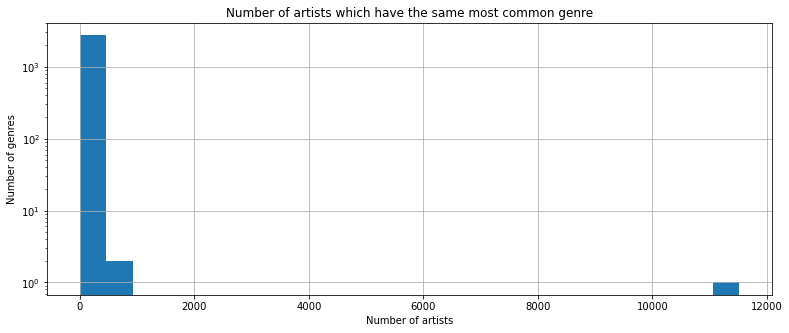

In [10]:
add_data.groupby('Most_common_genre').size().hist(bins = 25, figsize = (13, 5))
plt.yscale('log')
plt.title('Number of artists which have the same most common genre')
plt.xlabel('Number of artists')
_ = plt.ylabel('Number of genres')

In [12]:
add_data.groupby('Most_common_genre').size()

Most_common_genre
                    11522
a cappella             20
abstract                4
abstract beats          3
abstract hip hop       42
                    ...  
zim urban groove        1
zither                  1
zolo                   15
zouk                   13
zydeco                  1
Length: 2732, dtype: int64

In this case, we see that there are 11522 artists which do not have any genres attached to them, this probably comes from a lack of information about these artists in general from Spotify.

In [13]:
add_data = add_data[add_data['Genres'].map(len) > 0]

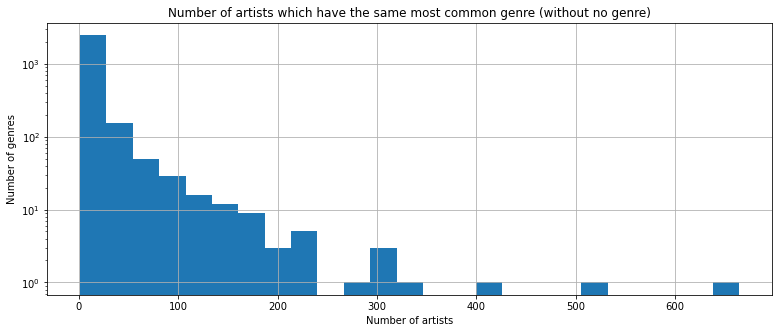

In [14]:
add_data.groupby('Most_common_genre').size().hist(bins = 25, figsize = (13, 5))
plt.yscale('log')
plt.title('Number of artists which have the same most common genre (without no genre)')
plt.xlabel('Number of artists')
_ = plt.ylabel('Number of genres')

In [26]:
top_data_percent = top_data.copy()
top_data_percent['Percent'] = top_data['Plays'] / top_data[['ID', 'Plays']].groupby('ID').Plays.transform('sum')
top_data_percent.head()

,ID,Artist_ID,Artist,Plays,Percent
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137,0.127842
1,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099,0.065745
2,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897,0.053661
3,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717,0.042893
4,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706,0.042235


In [27]:
all_data = top_data_percent.merge(add_data, on = 'Artist')
all_data.head()

,ID,Artist_ID,Artist,Plays,Percent,Info,Genres,best_genre,Popularity
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137,0.127842,{'external_urls': {'spotify': 'https://open.sp...,[riot grrrl],riot grrrl,19
1,0159d9ae1c8d76ab7fe3aa868a38e1da56cc06ab,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,42,0.011105,{'external_urls': {'spotify': 'https://open.sp...,[riot grrrl],riot grrrl,19
2,0285490bb23814cf0dc18a5668261e243572d4eb,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,41,0.010299,{'external_urls': {'spotify': 'https://open.sp...,[riot grrrl],riot grrrl,19
3,03d2e7186a6c29f281f6ff8b9bb2f7503822e7de,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,67,0.010819,{'external_urls': {'spotify': 'https://open.sp...,[riot grrrl],riot grrrl,19
4,04e0999468b2bbd922f0fdd41ffd9a5f26f97609,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,3,0.006122,{'external_urls': {'spotify': 'https://open.sp...,[riot grrrl],riot grrrl,19


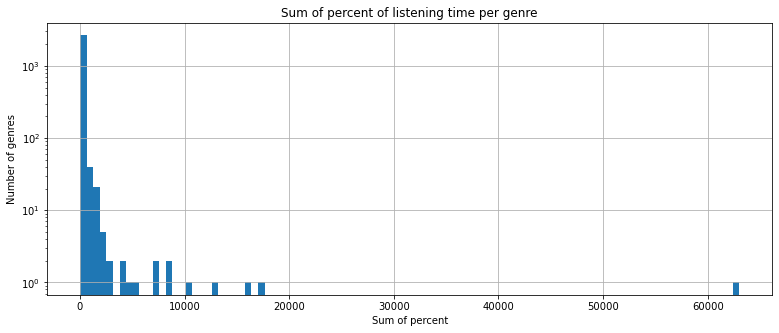

In [28]:
all_data[['best_genre', 'Percent']].groupby('best_genre').sum().hist(bins = 100, figsize = (13, 5))
plt.yscale('log')
plt.title('Sum of percent of listening time per genre')
plt.xlabel('Sum of percent')
_ = plt.ylabel('Number of genres')

In [29]:
all_data[['best_genre', 'Percent']].groupby('best_genre').sum().sort_values(by = 'Percent')

,Percent
best_genre,
kansas city hip hop,0.224099
belarusian pop,0.228380
ukrainian pop,0.242180
death doom,0.248212
backing track,0.254336
...,...
pop rock,10153.048772
electronica,13105.578309
alternative metal,16197.245614


# Artists and genres

In [10]:
merge_data = spotify_data.copy()
merge_data['Info'] = merge_data['Info'].map(lambda x: x if isinstance(x, str) else "{}").map(lambda x: ast.literal_eval(x))
merge_data.head()

,Artist,Info
0,!!!,{'external_urls': {'spotify': 'https://open.sp...
1,!action pact!,{'external_urls': {'spotify': 'https://open.sp...
2,!deladap,{'external_urls': {'spotify': 'https://open.sp...
3,!distain,{'external_urls': {'spotify': 'https://open.sp...
4,!t.o.o.h.!,{'external_urls': {'spotify': 'https://open.sp...


In [12]:
merge_data['Genres'] = merge_data['Info'].map(lambda x: x['genres'] if len(x) > 0 else [])
merge_data = merge_data[merge_data['Genres'].map(len) > 0]
merge_data.head()

,Artist,Info,Genres
0,!!!,{'external_urls': {'spotify': 'https://open.sp...,"[alternative dance, dance rock, dance-punk, el..."
1,!action pact!,{'external_urls': {'spotify': 'https://open.sp...,"[anarcho-punk, uk82]"
2,!deladap,{'external_urls': {'spotify': 'https://open.sp...,"[balkan brass, electro swing]"
3,!distain,{'external_urls': {'spotify': 'https://open.sp...,"[dark electro, futurepop, neo-synthpop]"
4,!t.o.o.h.!,{'external_urls': {'spotify': 'https://open.sp...,[technical grindcore]


In [20]:
knn_genres = merge_data.merge(top_artists, on = 'Artist')
knn_genres = knn_genres.merge(top_data, on = 'Artist')[['ID', 'Genres']].groupby('ID')['Genres'].apply(list).apply(lambda x: set([item for sublist in x for item in sublist])).reset_index(name = 'Genres')
knn_genres

,ID,Genres
0,00000c289a1829a808ac09c00daf10bc3c4e223b,"{skate punk, dark wave, dance pop, alternative..."
1,00001411dc427966b17297bf4d69e7e193135d89,"{garage rock revival, german techno, dance pop..."
2,00004d2ac9316e22dc007ab2243d6fcb239e707d,"{alternative dance, metropopolis, symphonic me..."
3,000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,"{dance pop, alternative rock, groove metal, sw..."
4,00007a47085b9aab8af55f52ec8846ac479ac4fe,"{microhouse, dance pop, alternative rock, pop ..."
...,...,...
357618,fffe8637bd8234309e871409c7ebef99a720afc1,"{dance pop, washington indie, alternative rock..."
357619,fffe8c7f952d9b960a56ed4dcb40a415d924b224,"{skate punk, post-rock, sacramento indie, alte..."
357620,ffff9af9ae04d263dae91cb838b1f3a6725f5ffb,"{skate punk, hard rock, alternative rock, rock..."
357621,ffff9ef87a7d9494ada2f9ade4b9ff637c0759ac,"{us power metal, groove metal, viking black me..."


In [21]:
genres = merge_data['Genres'].tolist()
all_genres = [item for sublist in genres for item in sublist]
unique_genres = set(all_genres)
len(unique_genres)

4258

In [22]:
from collections import Counter
c = Counter(all_genres)
c.most_common(10)

[('rock', 665),
 ('dance pop', 511),
 ('hip hop', 475),
 ('country rock', 460),
 ('pop rock', 454),
 ('pop', 449),
 ('rap', 415),
 ('mellow gold', 412),
 ('adult standards', 402),
 ('classic rock', 395)]

In [23]:
def best_genre(l, c) :
    best = ""
    best_num = 0
    for elem in l:
        if(c[elem] > best_num) :
            best = elem
            best_num = c[elem]
    return best

In [24]:
merge_data['Most_common_genre'] = merge_data['Genres'].map(lambda x: best_genre(x, c))
merge_data.head()

,Artist,Info,Genres,Most_common_genre
0,!!!,{'external_urls': {'spotify': 'https://open.sp...,"[alternative dance, dance rock, dance-punk, el...",electronica
1,!action pact!,{'external_urls': {'spotify': 'https://open.sp...,"[anarcho-punk, uk82]",uk82
2,!deladap,{'external_urls': {'spotify': 'https://open.sp...,"[balkan brass, electro swing]",balkan brass
3,!distain,{'external_urls': {'spotify': 'https://open.sp...,"[dark electro, futurepop, neo-synthpop]",neo-synthpop
4,!t.o.o.h.!,{'external_urls': {'spotify': 'https://open.sp...,[technical grindcore],technical grindcore


In [25]:
knn_best_genres = merge_data.merge(top_artists, on = 'Artist')
knn_best_genres = knn_best_genres.merge(top_data, on = 'Artist')[['ID', 'Most_common_genre']].groupby('ID')['Most_common_genre'].apply(set).reset_index(name = 'Genres')
knn_best_genres

,ID,Genres
0,00000c289a1829a808ac09c00daf10bc3c4e223b,"{power metal, rock, alternative metal, dance-p..."
1,00001411dc427966b17297bf4d69e7e193135d89,"{dance pop, alternative rock, melodic hardcore..."
2,00004d2ac9316e22dc007ab2243d6fcb239e707d,"{alternative metal, dance pop, black metal, go..."
3,000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,"{rock, alternative metal, symphonic rock, meta..."
4,00007a47085b9aab8af55f52ec8846ac479ac4fe,"{dance pop, turntablism, neo-synthpop, alterna..."
...,...,...
357618,fffe8637bd8234309e871409c7ebef99a720afc1,"{rock, dance pop, indie rock, sound, alternati..."
357619,fffe8c7f952d9b960a56ed4dcb40a415d924b224,"{alternative metal, rock, dance-punk, metal, a..."
357620,ffff9af9ae04d263dae91cb838b1f3a6725f5ffb,"{rock, p funk, psychedelic trance, gypsy punk,..."
357621,ffff9ef87a7d9494ada2f9ade4b9ff637c0759ac,"{power metal, rock, alternative metal, metal, ..."


# Percentage of plays per genre and user

First, let's create the dataset from the Spotify infos.

In [10]:
add_data = spotify_data.copy()
add_data['Info'] = add_data['Info'].map(lambda x: x if isinstance(x, str) else "{}").map(lambda x: ast.literal_eval(x))
add_data['Genres'] = add_data['Info'].map(lambda x: x['genres'] if len(x) > 0 else [])
add_data.head()

,Artist,Info,Genres
0,!!!,{'external_urls': {'spotify': 'https://open.sp...,"[alternative dance, dance rock, dance-punk, el..."
1,!action pact!,{'external_urls': {'spotify': 'https://open.sp...,"[anarcho-punk, uk82]"
2,!deladap,{'external_urls': {'spotify': 'https://open.sp...,"[balkan brass, electro swing]"
3,!distain,{'external_urls': {'spotify': 'https://open.sp...,"[dark electro, futurepop, neo-synthpop]"
4,!t.o.o.h.!,{'external_urls': {'spotify': 'https://open.sp...,[technical grindcore]


In [8]:
top_data_percent = top_data.copy()
top_data_percent['Percent'] = top_data['Plays'] / top_data[['ID', 'Plays']].groupby('ID').Plays.transform('sum')

In [13]:
df = top_data_percent.merge(add_data[['Artist', 'Genres']], on = 'Artist')
df.head()

,ID,Artist_ID,Artist,Plays,Percent,Genres
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137,0.127842,[riot grrrl]
1,0159d9ae1c8d76ab7fe3aa868a38e1da56cc06ab,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,42,0.011105,[riot grrrl]
2,0285490bb23814cf0dc18a5668261e243572d4eb,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,41,0.010299,[riot grrrl]
3,03d2e7186a6c29f281f6ff8b9bb2f7503822e7de,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,67,0.010819,[riot grrrl]
4,04e0999468b2bbd922f0fdd41ffd9a5f26f97609,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,3,0.006122,[riot grrrl]


In [17]:
df = df[df['Genres'].apply(len) > 0]
df

,ID,Artist_ID,Artist,Plays,Percent,Genres
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137,0.127842,[riot grrrl]
1,0159d9ae1c8d76ab7fe3aa868a38e1da56cc06ab,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,42,0.011105,[riot grrrl]
2,0285490bb23814cf0dc18a5668261e243572d4eb,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,41,0.010299,[riot grrrl]
3,03d2e7186a6c29f281f6ff8b9bb2f7503822e7de,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,67,0.010819,[riot grrrl]
4,04e0999468b2bbd922f0fdd41ffd9a5f26f97609,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,3,0.006122,[riot grrrl]
...,...,...,...,...,...,...
16712969,d375f346d239a15445b464c7b139b5f11641835b,NaN,as diabatz,149,0.009205,"[brazilian rockabilly, psychobilly, rock curit..."
16712970,d7a0a0d499c8f9e127d990d5b49225339ad572ba,NaN,as diabatz,120,0.005539,"[brazilian rockabilly, psychobilly, rock curit..."
16712971,dbdbcec60934d38e130c38cc65b29f56b7c2b8a5,NaN,as diabatz,224,0.025050,"[brazilian rockabilly, psychobilly, rock curit..."
16712972,ecfedd97388a4a2a3fa2bf7c7e3caa0ab0abf93e,NaN,as diabatz,284,0.011709,"[brazilian rockabilly, psychobilly, rock curit..."


In [29]:
def to_dict(row) :
    list_genres = row['Genres']
    percent = row['Percent']
    ret_dict = {}
    for g in list_genres :
        ret_dict[g] = percent
    return ret_dict

In [30]:
df['Genres_dict'] = df.apply(to_dict, axis = 1)
df = df[['ID', 'Genres_dict']]

<ipython-input-30-278cf0a5d37b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Genres_dict'] = df.apply(to_dict, axis = 1)


In [31]:
df.head()

,ID,Genres_dict
0,00000c289a1829a808ac09c00daf10bc3c4e223b,{'riot grrrl': 0.12784158889686528}
1,0159d9ae1c8d76ab7fe3aa868a38e1da56cc06ab,{'riot grrrl': 0.01110523532522475}
2,0285490bb23814cf0dc18a5668261e243572d4eb,{'riot grrrl': 0.010298919869379553}
3,03d2e7186a6c29f281f6ff8b9bb2f7503822e7de,{'riot grrrl': 0.010818666236072985}
4,04e0999468b2bbd922f0fdd41ffd9a5f26f97609,{'riot grrrl': 0.006122448979591836}


In [35]:
df2 = df.groupby('ID')['Genres_dict'].apply(list)

In [36]:
df2.head()

ID
00000c289a1829a808ac09c00daf10bc3c4e223b    [{'riot grrrl': 0.12784158889686528}, {'german...
00001411dc427966b17297bf4d69e7e193135d89    [{'ontario indie': 0.10642839869580807, 'toron...
00004d2ac9316e22dc007ab2243d6fcb239e707d    [{'ambient industrial': 0.14783362218370885, '...
000063d3fe1cf2ba248b9e3c3f0334845a27a6bf    [{'alternative metal': 0.18088737201365188, 'm...
00007a47085b9aab8af55f52ec8846ac479ac4fe    [{'alternative dance': 0.017825020441537203, '...
Name: Genres_dict, dtype: object

In [38]:
import collections, functools, operator
df2 = df2.apply(lambda x: dict(functools.reduce(operator.add, map(collections.Counter, x))))
df2.head()

ID
00000c289a1829a808ac09c00daf10bc3c4e223b    {'riot grrrl': 0.25263220866235936, 'german al...
00001411dc427966b17297bf4d69e7e193135d89    {'ontario indie': 0.10642839869580807, 'toront...
00004d2ac9316e22dc007ab2243d6fcb239e707d    {'ambient industrial': 0.22616984402079726, 'b...
000063d3fe1cf2ba248b9e3c3f0334845a27a6bf    {'alternative metal': 0.42150170648464164, 'me...
00007a47085b9aab8af55f52ec8846ac479ac4fe    {'alternative dance': 0.13605887162714636, 'ar...
Name: Genres_dict, dtype: object

# Probabilities and trimming explanation

First of all, let's set some variables, for simplicity we will assume a uniform distribution for the number of listeners and the number of artists that user listen to.

There are A artists which X listeners each and B users which are listening to Y artists each. We can deduce that $A * X = B * Y$. We have from our dataset that Y is more or less 50 which is the value we will use for the following equations and B is approximately 360'000.

There are C users per group, which means that they are going to be $C * 50$ artists per group (not necessarily unique). Here we will set C to 5.

We want to compute the probability of having Z same artists :

$$P(Z = 0) = \frac{\frac{A!}{(A-250)!}}{(\frac{A!}{(A-50)!})^5} = \frac{((A-50)!)^5}{(A - 250)! * (A!)^4}$$
$$P(Z = 0) < 0.05 \iff A < 8500$$

This means that we would need $X = \frac{B * Y}{A} = \frac{360000 * 50}{8500} \approx 2118$ listeners per artist.